In [1]:
# https://discuss.pytorch.org/t/i-have-3-gpu-why-torch-cuda-device-count-only-return-1/7245/4
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION
/usr/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 8003
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import json

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

from dataraw_sampling import sample_dataset, plot_sampled_distribution
from dataraw_full_matrix import gen_card_data, report_gamedata_distribution
from util_distribution import plot_distribution
from dataset import GameDatasetFromFullMatrix, GameTestFullDataset, GameDatasetTrainDataset
from datamodule import GameDataModule
from model import construct_full_model
from trainmodule import ContrastiveTrainModule, GenerativeTrainModule

from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

In [ ]:
# arguments
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.gpu = 0
args.generate_full_matrix = True
args.data_PATH = '../Raw_Datasets/3Attr-4Vals-2hat23Train-2hat12Val.json'
args.config_PATH = 'checkpoints/ContrastiveLearning-cardgame-Scaling-SecondPass/CardGame:OR;attr3-val4;d_model8;dot-product;params33.29K/config.json'

In [ ]:
# generate on the fly -- becareful of sampling time
# num_attributes = 2
# num_attr_vals = 3
# game_data = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)

# read from disk instead
with open(args.data_PATH, 'r') as f:
    game_data = json.load(f)

print('----------data----------')
for k in game_data:
    if not 'datapoints' in k:
        print(k,':', game_data[k])
    else:
        print(k,'length :', len(game_data[k]))
print('------------------------')

In [ ]:
# read from disk instead
with open(args.config_PATH, 'r') as f:
    hparams = json.load(f)

hparams['key_support_size'] = game_data['key_support_size']
hparams['query_support_size'] = game_data['query_support_size']
hparams['num_attributes'] = game_data['num_attributes']
hparams['num_attr_vals'] = game_data['num_attr_vals']
hparams['populate_logits_matrix'] = args.generate_full_matrix
if 'embedding_by_property' not in params:
    hparams['populate_logits_matrix'] = False    
    
print('----------hparams----------')
for k in hparams:
    print(k, ':', hparams[k])
print('---------------------------')

In [ ]:
# main() do this only if data is small
if args.generate_full_matrix:
    print('Generating Full Matrix')
    game_data_full = gen_card_data(hparams['num_attributes'], hparams['num_attr_vals'], num_unseen_cardpairs=0, debug=False)
    count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data_full, distribution_epsilon=0.0)
    gt = {
        'count_table':count_table,
        'xy':xy,
        'xyind':xyind,
        'xy_div_xyind':xy_div_xyind,
        'distribution':distribution
    }
    print(distribution)
else:
    gt = None

In [ ]:
# main()

pl.seed_everything(hparams['seed'])

# model
trainmodule =  ContrastiveTrainModule(hparams, gt_distributions=gt if args.generate_full_matrix else {})
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# dataset
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    embedding_by_property = hparams['embedding_by_property'],
    debug=hparams['debug']
)

# testloader
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=hparams['debug']), 
            batch_size=hparams['batch_size'], shuffle=False
        )

# logger
run_name = 'CardGame:OR;attr{}-val{};d_model{};{};params{}K'.format(
    hparams['num_attributes'], hparams['num_attr_vals'], 
    hparams['d_model'],  
    'dot-product' if hparams['dotproduct_bottleneck'] else '',
    round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling-SecondPass'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)

# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)
os.makedirs(ckpt_dir_PATH, exist_ok=True)

## run testing

In [ ]:
%load_ext autoreload
%autoreload 2

from main import run_test
import torch.nn as nn
import torch

import numpy as np
from collections import Counter
from dataraw_sampling import decode_query_idx, queryidx_to_querypair, check_q1q2k_match

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
ckpt_name = 'epoch=00-step=17999-val_loss=497.78.ckpt'

test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=False), 
            batch_size=hparams['batch_size'], shuffle=False
        )

run_test(args, hparams, ckpt_name, gt, test_loader, trainmodule, ckpt_dir_PATH, figsize=(10,15))

In [ ]:
softmax = nn.Softmax(dim=0)
threshold = 1 / trainmodule.hparams['key_support_size']
gt_labels = ((trainmodule.gt_xy) > 0).type(torch.int)
binary_predictions = (softmax(trainmodule.model_logits_matrix) >= threshold).type(torch.float)
wrongs = binary_predictions != gt_labels
print('Overall accuracy =', torch.sum(binary_predictions.type(torch.int) == gt_labels).item() / (trainmodule.hparams['key_support_size']*trainmodule.hparams['query_support_size']))
print('Number of inaccurate predictions = ', torch.sum(wrongs).item(),'/', trainmodule.hparams['key_support_size']*trainmodule.hparams['query_support_size'])

In [ ]:
torch.sum(binary_predictions.type(torch.int) == gt_labels).item() / (trainmodule.hparams['key_support_size']*trainmodule.hparams['query_support_size'])

In [173]:
def construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key=None):
    '''compute filters'''
    keep_queries = []
    keep_querykeys = np.zeros(trainmodule.gt_xy.shape)
    for i in range((trainmodule.hparams['query_support_size'])):
        card1, card2 = queryidx_to_querypair(trainmodule.hparams['num_attributes'], trainmodule.hparams['num_attr_vals'], i)
        if np.sum(card1 == card2) == num_attr_shared_in_query:
            keep_queries.append(True)
            for j in range(trainmodule.hparams['key_support_size']):
                num_matches = check_q1q2k_match(trainmodule.hparams['num_attributes'], trainmodule.hparams['num_attr_vals'], card1, card2, j)
                if num_matches == num_attr_hit_by_key:
                    keep_querykeys[j,i] = 1.0
        else:
            keep_queries.append(False)

    return keep_queries, keep_querykeys

def find_rank(keep_queries, keep_querykeys, count_table, num_attr_shared_in_query, num_attr_hit_by_key):
    print('Number of shared attributes in query cards = ', num_attr_shared_in_query)
    print('Number of attributes hits by key cards = ', num_attr_hit_by_key if num_attr_hit_by_key else 'None')
    print('matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys)[:,keep_queries]))
    u,s,vh = np.linalg.svd((count_table * keep_querykeys)[:,keep_queries]) 
    print('s values:', Counter(list(s//1)).most_common())
    num_filtered_wrongs = int(np.sum(keep_querykeys * wrongs.cpu().numpy()))
    num_filtered = int(np.sum(keep_querykeys))
    print('Number of mistakes made by model = ', num_filtered_wrongs, '/', num_filtered, '=', (num_filtered_wrongs*1.0/num_filtered))
    plt.plot(s)    

------Ground-truth--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  3
matrix rank =  64
s values: [(1.0, 64)]
Number of mistakes made by model =  0 / 64 = 0.0


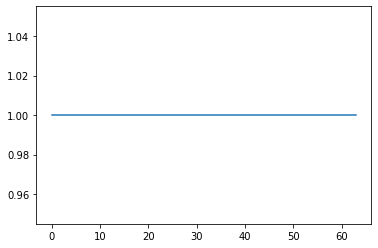

------Predicted--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  3
matrix rank =  64
s values: [(1.0, 64)]
Number of mistakes made by model =  0 / 64 = 0.0


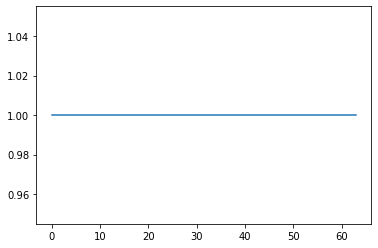

In [174]:
num_attr_shared_in_query = 3
num_attr_hit_by_key = 3
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

In [ ]:
# 0 : 0 0 0
# 1 : 0 0 1
# 2 : 0 0 2
# 3 : 0 0 3
# 80: 0 0 80
# 81: 0 1 0

# 531440: 80 80 80

In [3]:
81**3 - 1

531440

In [4]:
531440 % 81

80

In [5]:
531440 // 81

6560

In [8]:
6560 % 81

80

In [9]:
6560 // 81

80

In [10]:
80 % 81

80

In [11]:
80 // 81

0

------Ground-truth--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  2
matrix rank =  64
s values: [(2.0, 17), (1.0, 15), (0.0, 12), (3.0, 10), (5.0, 6), (4.0, 3), (8.0, 1)]
Number of mistakes made by model =  2 / 576 = 0.003472222222222222


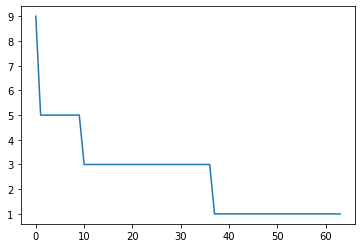

------Predicted--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  2
matrix rank =  64
s values: [(2.0, 16), (1.0, 14), (0.0, 13), (3.0, 11), (5.0, 5), (4.0, 4), (8.0, 1)]
Number of mistakes made by model =  2 / 576 = 0.003472222222222222


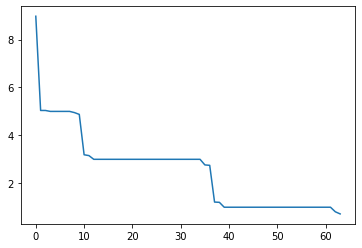

In [175]:
num_attr_shared_in_query = 3
num_attr_hit_by_key = 2
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  1
matrix rank =  64
s values: [(3.0, 20), (5.0, 19), (2.0, 16), (4.0, 8), (27.0, 1)]
Number of mistakes made by model =  1054 / 1728 = 0.6099537037037037


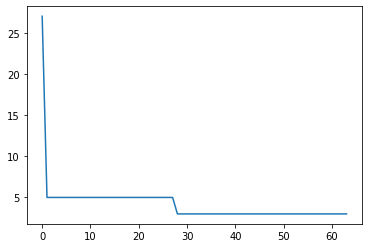

------Predicted--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  1
matrix rank =  64
s values: [(0.0, 20), (1.0, 11), (2.0, 10), (3.0, 9), (4.0, 8), (5.0, 4), (12.0, 1), (6.0, 1)]
Number of mistakes made by model =  1054 / 1728 = 0.6099537037037037


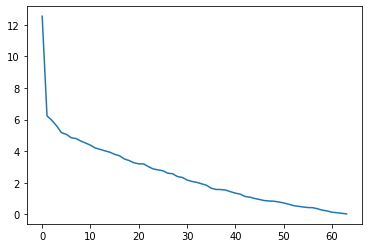

In [176]:
num_attr_shared_in_query = 3
num_attr_hit_by_key = 1
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  None
matrix rank =  0
s values: [(0.0, 64)]
Number of mistakes made by model =  26 / 1792 = 0.014508928571428572


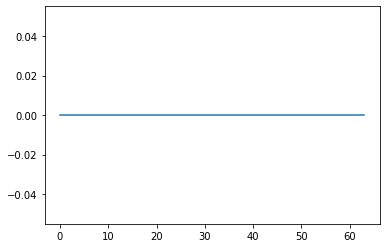

------Predicted--------
Number of shared attributes in query cards =  3
Number of attributes hits by key cards =  None
matrix rank =  10
s values: [(0.0, 59), (2.0, 2), (1.0, 2), (3.0, 1)]
Number of mistakes made by model =  26 / 1792 = 0.014508928571428572


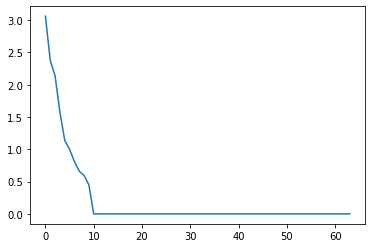

In [185]:
num_attr_shared_in_query = 3
num_attr_hit_by_key = 0
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  2
matrix rank =  37
s values: [(0.0, 28), (6.0, 27), (9.0, 9), (12.0, 1)]
Number of mistakes made by model =  0 / 2304 = 0.0


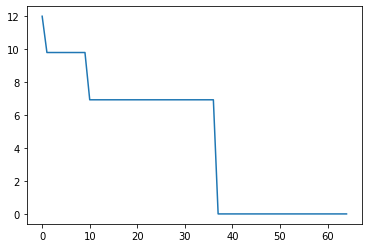

------Predicted--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  2
matrix rank =  37
s values: [(0.0, 28), (6.0, 27), (9.0, 9), (12.0, 1)]
Number of mistakes made by model =  0 / 2304 = 0.0


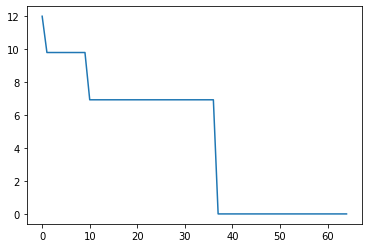

In [177]:
num_attr_shared_in_query = 2
num_attr_hit_by_key = 2
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  1
matrix rank =  37
s values: [(0.0, 28), (13.0, 27), (19.0, 9), (72.0, 1)]
Number of mistakes made by model =  4167 / 13824 = 0.3014322916666667


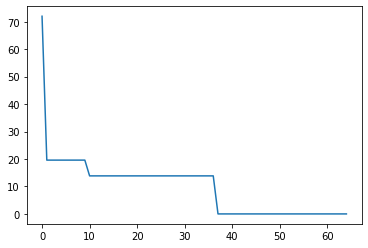

------Predicted--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  1
matrix rank =  64
s values: [(3.0, 14), (4.0, 9), (5.0, 4), (2.0, 4), (17.0, 3), (13.0, 3), (11.0, 3), (9.0, 3), (7.0, 3), (18.0, 2), (16.0, 2), (15.0, 2), (12.0, 2), (10.0, 2), (8.0, 2), (51.0, 1), (22.0, 1), (21.0, 1), (20.0, 1), (19.0, 1), (6.0, 1), (0.0, 1)]
Number of mistakes made by model =  4167 / 13824 = 0.3014322916666667


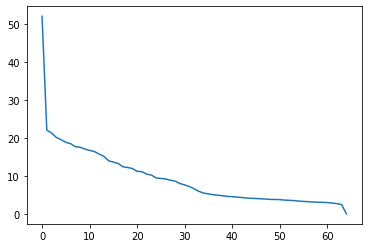

In [178]:
num_attr_shared_in_query = 2
num_attr_hit_by_key = 1
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  None
matrix rank =  0
s values: [(0.0, 65)]
Number of mistakes made by model =  180 / 21312 = 0.008445945945945946


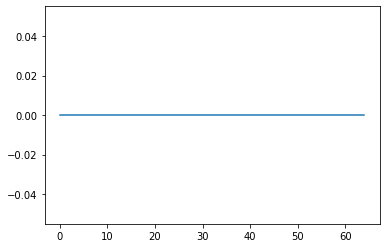

------Predicted--------
Number of shared attributes in query cards =  2
Number of attributes hits by key cards =  None
matrix rank =  19
s values: [(0.0, 50), (1.0, 7), (2.0, 5), (7.0, 2), (3.0, 1)]
Number of mistakes made by model =  180 / 21312 = 0.008445945945945946


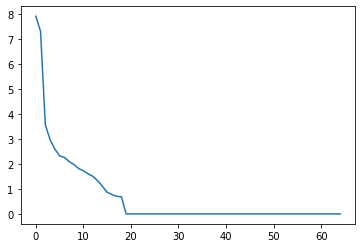

In [186]:
num_attr_shared_in_query = 2
num_attr_hit_by_key = 0
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  1
Number of attributes hits by key cards =  1
matrix rank =  10
s values: [(0.0, 55), (47.0, 6), (48.0, 3), (83.0, 1)]
Number of mistakes made by model =  0 / 27648 = 0.0


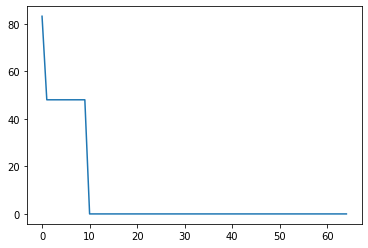

------Predicted--------
Number of shared attributes in query cards =  1
Number of attributes hits by key cards =  1
matrix rank =  10
s values: [(0.0, 55), (47.0, 6), (48.0, 3), (83.0, 1)]
Number of mistakes made by model =  0 / 27648 = 0.0


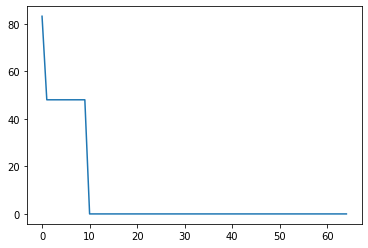

In [179]:
num_attr_shared_in_query = 1
num_attr_hit_by_key = 1
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  1
Number of attributes hits by key cards =  None
matrix rank =  0
s values: [(0.0, 65)]
Number of mistakes made by model =  1 / 84672 = 1.1810279667422525e-05


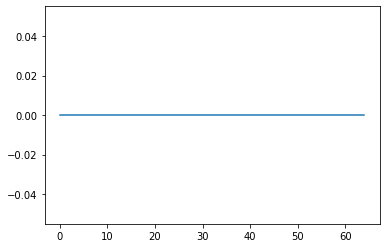

------Predicted--------
Number of shared attributes in query cards =  1
Number of attributes hits by key cards =  None
matrix rank =  1
s values: [(0.0, 64), (1.0, 1)]
Number of mistakes made by model =  1 / 84672 = 1.1810279667422525e-05


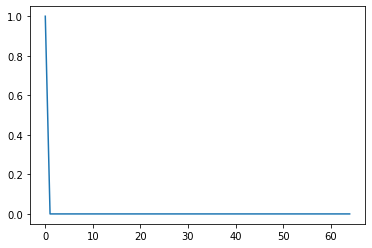

In [187]:
num_attr_shared_in_query = 1
num_attr_hit_by_key = 0
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  0
Number of attributes hits by key cards =  1
matrix rank =  1
s values: [(0.0, 64), (41.0, 1)]
Number of mistakes made by model =  0 / 1728 = 0.0


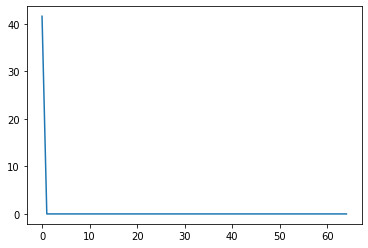

------Predicted--------
Number of shared attributes in query cards =  0
Number of attributes hits by key cards =  1
matrix rank =  1
s values: [(0.0, 64), (41.0, 1)]
Number of mistakes made by model =  0 / 1728 = 0.0


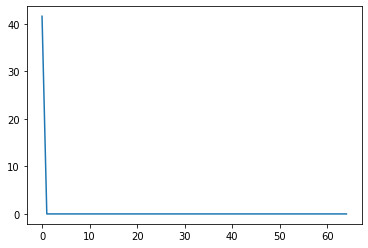

In [184]:
num_attr_shared_in_query = 0
num_attr_hit_by_key = 1
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()

------Ground-truth--------
Number of shared attributes in query cards =  0
Number of attributes hits by key cards =  None
matrix rank =  0
s values: [(0.0, 65)]
Number of mistakes made by model =  0 / 110592 = 0.0


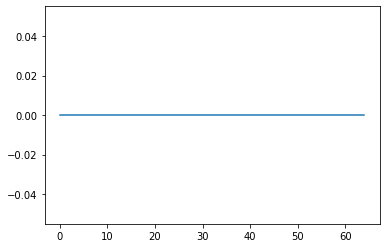

------Predicted--------
Number of shared attributes in query cards =  0
Number of attributes hits by key cards =  None
matrix rank =  0
s values: [(0.0, 65)]
Number of mistakes made by model =  0 / 110592 = 0.0


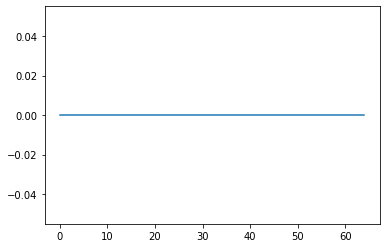

In [188]:
num_attr_shared_in_query = 0
num_attr_hit_by_key = 0
keep_queries, keep_querykeys = construct_filter(trainmodule, num_attr_shared_in_query, num_attr_hit_by_key)
print('------Ground-truth--------')
find_rank(keep_queries, keep_querykeys, gt_labels.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()
print('------Predicted--------')
find_rank(keep_queries, keep_querykeys, binary_predictions.cpu().numpy(), num_attr_shared_in_query, num_attr_hit_by_key)
plt.show()